## Introduction

training a custom music genre classification system with the GTZAN dataset. The model takes as an input the spectogram of music frames and analyzes the image using a Convolutional Neural Network (CNN) or a Recurrent Neural Network (RNN). The output of the system is a vector of predicted genres for the song.

 ## Data Dictionary
    
        "blues" = 1,
        "classical" = 2,
        "country" = 3,
        "disco" = 4,
        "hiphop" = 5,
        "jazz"  = 6,
        "metal" = 7,
        "pop" = 8,
        "rock" = 9

## Loading and splitting the data 

In [2]:
import numpy as np
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
DATASET_PATH = "data.json"

In [4]:
def prepare_datasets(test_size, validation_size):
    #load data
    X, y = load_data(DATASET_PATH)
    # train/test split & train/validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    
    # for a CNN , Tensorflow expects a 3D array for each sample? --> (130 time bins and 13 mfccs)

    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [5]:

def load_data(dataset_path):
    with open(dataset_path, "r") as file:
        data = json.load(file)
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print("Data succesfully loaded!")

    return  X, y
    
if __name__ == "__main__":
    
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)
    
    

Data succesfully loaded!


## Building the network architecture with keras

In [6]:
input_shape = (X_train.shape[1], X_train.shape[2])

In [7]:
def build_model(input_shape):
    #create RNN-LSTM model
    model = keras.Sequential()
    #1st layer
    model.add(layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(128))
    #dense layer
    keras.layers.BatchNormalization(epsilon=0.001)
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))
    keras.layers.BatchNormalization(epsilon=0.001)
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.4))
    keras.layers.BatchNormalization(epsilon=0.001)

    # output
    model.add(layers.Dense(10, activation='softmax'))
    
    return model
    

In [8]:
keras.backend.clear_session()
model = build_model(input_shape)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 128)          72704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                6

## Compile and train the network

In [72]:
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [73]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50, callbacks=[es_callback])

Train on 592 samples, validate on 149 samples
Epoch 1/50
592/592 [==============================] - 6s 10ms/sample - loss: 2.1009 - accuracy: 0.2601 - val_loss: 1.6753 - val_accuracy: 0.4899
Epoch 2/50
592/592 [==============================] - 2s 3ms/sample - loss: 1.6087 - accuracy: 0.4291 - val_loss: 1.1248 - val_accuracy: 0.6376
Epoch 3/50
592/592 [==============================] - 2s 3ms/sample - loss: 1.1316 - accuracy: 0.6064 - val_loss: 0.7928 - val_accuracy: 0.7651
Epoch 4/50
592/592 [==============================] - 2s 3ms/sample - loss: 0.9233 - accuracy: 0.7044 - val_loss: 0.7330 - val_accuracy: 0.7248
Epoch 5/50
592/592 [==============================] - 2s 3ms/sample - loss: 0.8205 - accuracy: 0.7247 - val_loss: 0.4996 - val_accuracy: 0.8255
Epoch 6/50
592/592 [==============================] - 2s 3ms/sample - loss: 0.7118 - accuracy: 0.7669 - val_loss: 0.4805 - val_accuracy: 0.8121
Epoch 7/50
592/592 [==============================] - 2s 3ms/sample - loss: 0.5266 - accu

In [74]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Accuracy on test set is: {test_accuracy}")

248/248 [==============================] - 0s 1ms/sample - loss: 0.4841 - accuracy: 0.8871
Accuracy on test set is: 0.8870967626571655


In [75]:
def predict(model, X, y):
    X = X[np.newaxis, ...]
    # prediction = [[0.1, 0.2, ...]]
    prediction = model.predict(X)
    #extract index with max value
    predicted_index = np.argmax(prediction, axis=1) # [i] index that is predicted
    print(f"Expected index: {y}, predicted index: {predicted_index}")

In [76]:
for i in range(0, 110, 10):
    X = X_test[i]
    y = y_test[i]
    predict(model, X, y)

Expected index: 7, predicted index: [7]
Expected index: 4, predicted index: [4]
Expected index: 7, predicted index: [7]
Expected index: 1, predicted index: [9]
Expected index: 1, predicted index: [1]
Expected index: 3, predicted index: [3]
Expected index: 3, predicted index: [8]
Expected index: 9, predicted index: [1]
Expected index: 3, predicted index: [3]
Expected index: 5, predicted index: [5]
Expected index: 4, predicted index: [4]


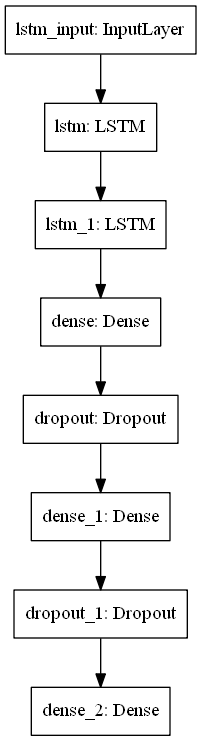

In [10]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)